# Adaptation of "Reconstruction of plant--pollinator networks from observational data" applied to foodweb bay-wet

*Authors*: Hugo Gorbato Souto and Tatiana Farane Mein  
*Date*: June 2025

## Bayesian Inference of Trophic Interactions in the FOODWEB-BAYWET Network

This notebook presents a Bayesian reconstruction of trophic interactions for the **FOODWEB-BAYWET** dataset—a seasonal food web corresponding to the wet period in the Florida cypress wetland ecosystem. Leveraging the probabilistic framework introduced by **Young et al. (2021)**, we estimate the latent structure of the network from empirical counts of carbon flow among taxa.

The model integrates ecological complexity and sampling uncertainty to infer:

- Posterior probabilities of interaction presence between consumers and resources  
- A posterior predictive matrix representing expected trophic flows  
- Macrostructural properties such as connectance, nestedness, and the strength of interaction preferences

Given the higher complexity and diffuseness expected during the wet season, this analysis highlights differences in inferred interaction strength, network sparsity, and model uncertainty relative to the dry-season counterpart.

---

### Notes on Figure Labeling and Replication

This notebook mirrors the dry-season analysis in structure and purpose, aiming to assess how well the inference method from Young et al. (2021) performs across contrasting ecological regimes.

To support this comparison, plots that replicate core figures from the original paper are explicitly labeled. These figure tags ensure conceptual continuity, even though the order or style may differ from the article.

Where appropriate, we also include additional visualizations that extend the original framework—such as residual distributions, posterior uncertainty bounds, and interaction heatmaps. These supplemental plots are unlabeled but provide deeper insight into seasonal variation in model fit and ecological interpretation.

By aligning key outputs with those from both the original publication and the dry-season analysis, this notebook offers a comparative Bayesian perspective on seasonal food web dynamics in a complex wetland ecosystem.

### Loading Data and Modules

#### Preparing the FOODWEB-BAYWET Interaction Matrix

We begin by importing the necessary libraries and project-specific modules:

- `numpy`: numerical computation and matrix manipulation  
- `matplotlib.pyplot`: plotting and visualization  
- `%matplotlib inline`: ensures inline display of plots in Colab  
- `utilities`: helper functions for matrix transformation and sorting  
- `plant_pol_inference_Hugo_Tati`: Bayesian inference implementation adapted from Young et al.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import utilities as ut
import plant_pol_inference_Hugo_Tati as pp

### Loading the Interaction Matrix

We specify the file and formatting options for reading the `FOODWEB-BAYWET` interaction matrix:

- `filename`: Path to the data file containing the trophic interaction matrix.
- `delimiter = None`: Indicates that whitespace should be used to split columns (handles irregular spacing).
- `comment_char = "#"`: Lines starting with this character will be treated as comments and ignored during parsing.

In [ ]:
filename = "eco-foodweb-baywet.txt"  # <-- Make sure this is the correct path to your file
delimiter = None       # Use whitespace as delimiter (split() with None handles multiple spaces)
comment_char = "#"     # Lines starting with '%' are comments

### Reading the Weighted Edge List

We now load the empirical interaction data from the `FOODWEB-BAYWET` dataset using a custom utility function.

- The file contains a list of directed, weighted trophic interactions (e.g., who eats whom and how much).
- The function `read_weighted_edgelist_to_sparse_adjacency()` returns:
  - `weighted_adj_matrix`: a sparse matrix encoding interaction strengths between taxa.
  - `total_num_nodes_in_network`: the maximum node ID, used to define the square shape of the matrix.

### Dataset Summary

After loading the `FOODWEB-BAYWET` edge list, we obtain the following characteristics:

- 2,106 trophic interactions were recorded in the dataset. Each edge corresponds to a directed, weighted link from one taxon to another, representing a feeding relationship and its intensity.

- The maximum node ID is 128, indicating that the dataset contains 128 unique taxa. These taxa include both resource (prey) and consumer (predator) species.

- Based on this, we construct a 128×128 weighted adjacency matrix, where:
  - Each row corresponds to a resource taxon,
  - Each column corresponds to a consumer taxon, and
  - Each entry stores the total carbon flow or biomass transfer from the resource to the consumer.

This matrix will serve as the empirical input to our Bayesian inference framework.

In [ ]:
# Call the function to load the weighted adjacency matrix
weighted_adj_matrix, total_num_nodes_in_network = pp.read_weighted_edgelist_to_sparse_adjacency(filename, delimiter, comment_char)


Successfully read 2106 edges.
Max node ID found: 128. Creating a 128x128 matrix.


### Adjacency Matrix Structure

We now inspect its contents using the `.toarray()` method.

This operation converts the sparse matrix into a dense format for visualization and diagnostics.

Each matrix entry $(i, j)$ represents the empirical strength of the directed trophic interaction from taxon $i$ (resource) to taxon $j$ (consumer):

- Values greater than zero indicate observed biomass or carbon flow from $i$ to $j$.
- Zeros denote the absence of direct interaction.
- The wide range of nonzero values reflects the heterogeneity in interaction intensities—some taxa interact frequently or strongly, while others contribute minimally.

Visual inspection confirms that:

- The matrix is highly sparse, with interactions concentrated in specific regions.
- The matrix structure is asymmetric, consistent with the directionality of trophic flows.
- This representation provides a quantitative foundation for probabilistic modeling of missing or uncertain interactions.

We now proceed to normalize and transform this empirical data for Bayesian inference.

In [ ]:
weighted_adj_matrix.toarray()

array([[ 0.      ,  5.217257, 73.88673 , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

### Converting to Dense Interaction Matrix

We convert the sparse adjacency matrix to a dense NumPy array using:

M = weighted_adj_matrix.toarray()

This step stores the full interaction matrix in memory as a standard 2D NumPy array, which enables direct use in visualization routines (e.g., using `matplotlib`), facilitates numerical analysis and diagnostics, and allows the matrix to be passed into model functions such as those used to compute likelihoods or priors.

The resulting matrix `M` has the same structure as the original sparse form: it is a \(128 \times 128\) matrix corresponding to the number of taxa in the ecosystem, where each entry \(M_{ij}\) represents the total observed carbon flow from taxon \(i\) to taxon \(j\). This dense matrix now serves as the empirical input to the Bayesian inference framework.

In [ ]:
M = weighted_adj_matrix.toarray()

To simplify further analysis, we convert the matrix `M` from floating-point to integer values using `M = M.astype(int)`. This step transforms each carbon flow value to its integer equivalent, effectively rounding the biomass transfer values to whole-number interaction counts.

In the context of Bayesian inference for trophic networks, this transformation facilitates the application of Poisson-based likelihood models, which assume discrete event counts (e.g., number of feeding events). It also improves the clarity of certain visualizations by reducing the visual noise introduced by small fractional weights.

In [ ]:
M=M.astype(int)

The output of `np.diag(M)` confirms that all diagonal entries in the interaction matrix `M` are zero.

This means that no taxon interacts with itself in the empirical data—there are no self-loops (i.e., no cases where a species consumes itself). This property is consistent with ecological expectations for trophic networks, where self-feeding is biologically implausible and typically excluded from data collection and modeling.

This diagonal structure further validates the integrity of the input data before proceeding with Bayesian inference.

In [ ]:
np.diag(M)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

We now sort the interaction matrix using a helper function from the `utilities` module:

`M = ut.sort(M, M)`

This operation reorders rows and columns based on interaction structure, which helps with visual clarity in subsequent matrix plots and improves model behavior by grouping densely connected taxa.

After sorting, we extract the matrix dimensions:

- `n_p = M.shape[0]` sets the number of resource taxa (rows),
- `n_a = M.shape[1]` sets the number of consumer taxa (columns).

In this case, both values are `128`, consistent with the original dataset. This indicates a square matrix with 128 unique taxa participating as both potential resources and consumers.

In [ ]:

M = ut.sort(M, M)
n_p = M.shape[0]
n_a = M.shape[1]

In [ ]:
n_p

128

In [ ]:
n_a

128

### Visualizing the Empirical Interaction Matrix

We now visualize the full interaction matrix `M` as a heatmap to understand the structure of the empirical data:

- Each cell at position \((i, j)\) shows the total observed carbon flow from taxon \(i\) to taxon \(j\).
- Darker shades of blue represent higher interaction counts (stronger trophic links).
- The matrix is highly sparse, with most interactions concentrated in the upper-left corner, suggesting a core set of active taxa.

This figure (Fig. 1(a)) provides a direct view of the empirical trophic structure observed during the wet season in the South Florida ecosystem.


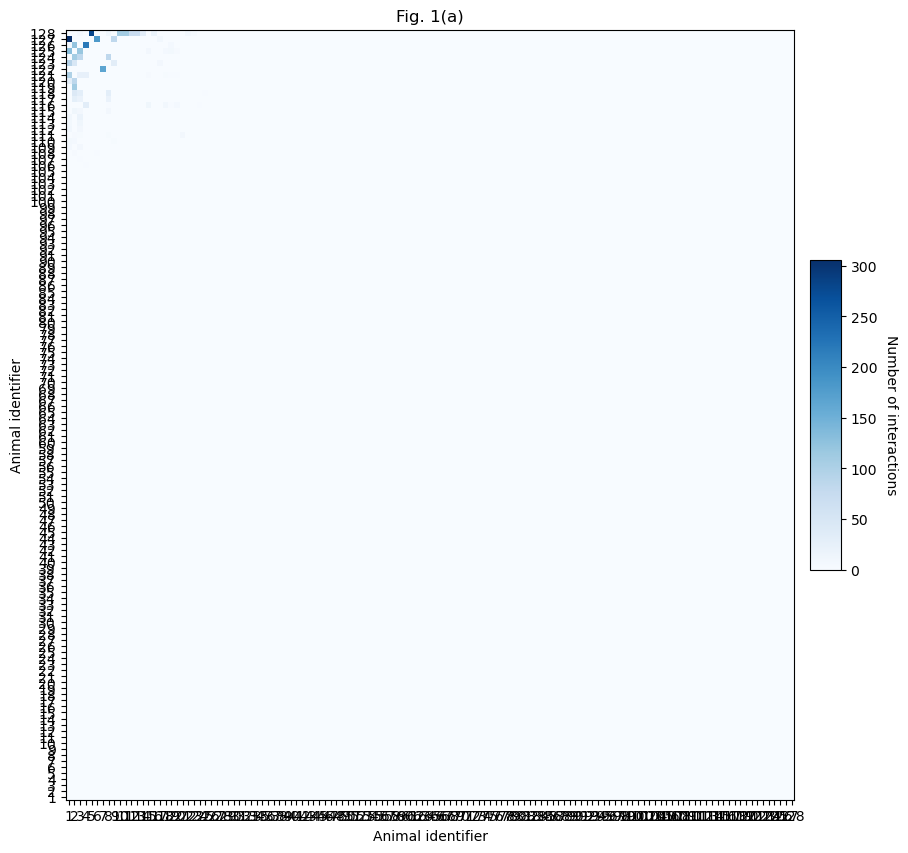

In [ ]:
plt.figure(figsize=(10,10))
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.title("Fig. 1(a)")
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Animal identifier')
plt.ylabel('Animal identifier')
plt.show()

## Pystan model

### Stan Model Explanation

This Stan program defines a hierarchical Bayesian model for inferring latent ecological interactions in a directed, weighted trophic network. It closely follows the framework introduced by Young et al. (2020), with necessary adjustments for trophic flow data like that in the `FOODWEB-BAYWET` dataset.

#### Overview of Each Block

**Data Block**  
Specifies the input matrix `M` and its dimensions:
- `n_p`: number of resource taxa (rows),
- `n_a`: number of consumer taxa (columns),
- `M`: the observed interaction matrix (carbon flow between taxa).

**Transformed Data Block**  
Precomputes three important summary statistics:
- `M_rows`: total outflow per resource taxon,
- `M_cols`: total inflow per consumer taxon,
- `M_tot`: total carbon flow in the entire system.

These are used to simplify and speed up computations during model fitting.

**Parameters Block**  
Declares the model's latent variables:
- `C`: global sampling effort,
- `r`: interaction preference multiplier,
- `sigma`: relative abundances of resource taxa (simplex),
- `tau`: relative abundances of consumer taxa (simplex),
- `rho`: global connectance (interaction probability).

**Model Block**  
Defines the joint log-likelihood, with three components:
1. Poisson-like term for the total interaction magnitude using `C`,
2. Marginal likelihoods for taxa-specific abundances using `sigma` and `tau`,
3. Pairwise interaction structure using a mixture model:
   - Each entry `(i, j)` is modeled as coming from a mixture of two components:
     - a zero interaction term (`nu_ij_0`) and
     - a nonzero interaction term (`nu_ij_1`),
   - combined using a log-sum-exp trick for numerical stability.

**Generated Quantities Block**  
Computes the posterior interaction probability matrix `Q`, where `Q[i, j]` reflects the estimated probability that consumer `j` consumes resource `i`. This output is crucial for:
- visualizing inferred interactions,
- computing network metrics (e.g., connectance, nestedness),
- comparing with the empirical matrix `M`.


In [ ]:
with open('model.stan', 'r') as f:
    print(f.read())

data {
  // Dimensions of the data matrix, and matrix itself.
  int<lower=1> n_p;
  int<lower=1> n_a;
  int<lower=0> M[n_p, n_a];
}
transformed data {
  // Pre-compute the marginals of M to save computation in the model loop.
  int M_rows[n_p] = rep_array(0, n_p);
  int M_cols[n_a] = rep_array(0, n_a);
  int M_tot = 0;
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      M_rows[i] += M[i, j];
      M_cols[j] += M[i, j];
      M_tot += M[i, j];
    }
  }
}
parameters {
  real<lower=0> C;
  real<lower=0> r;
  simplex[n_p] sigma;
  simplex[n_a] tau;
  real<lower=0, upper=1> rho;
}
model {
  // Global sums and parameters
  target += M_tot * log(C) - C;
  // Weighted marginals of the data matrix 
  for (i in 1:n_p) {
    target += M_rows[i] * log(sigma[i]);
  }
  for (j in 1:n_a) {
    target += M_cols[j] * log(tau[j]);
  }
  // Pairwise loop
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      real nu_ij_0 = log(1 - rho);
      real nu_ij_1 = log(rho) + M[i,j] * log(1 + r) - C * r * sigma[i] * t

## Compiling the model

### Loading the Stan Model

The command `model = pp.load_model()` loads the compiled Stan model from file. This function wraps the process of reading the `model.stan` file and compiling it into an object that can be used for sampling.

Once loaded, this model object contains the full specification of the Bayesian inference procedure, including data structure, parameter definitions, likelihood functions, and posterior quantities. It is ready to be passed to a sampling interface like CmdStanPy or PyStan for inference using the observed data matrix `M`.

In [ ]:
model = pp.load_model()

c:\Users\hugog\Desktop\Master_Courses\Complex_Networks\Project\projeto\model.bin [Skipping --- already compiled]


## Sampling

### Sampling from the Posterior

The command `samples = pp.generate_sample(M, model, warmup=2000, num_samples=500)` initiates posterior sampling using Hamiltonian Monte Carlo (HMC). It uses the observed interaction matrix `M` and the compiled Stan model to estimate the posterior distributions of the latent variables and parameters.

- `warmup=2000`: uses 2,000 iterations to tune the sampler.
- `num_samples=500`: draws 500 post-warmup samples per chain for inference.

The resulting `samples` object stores posterior draws for all model parameters and generated quantities.

**Diagnostic Warning**:  
A warning is issued by PyStan: _"Maximum (flat) parameter count (1000) exceeded: skipping diagnostic tests for n_eff and Rhat."_
This indicates the model has many parameters, and some automatic diagnostics have been skipped.

In practice, such warnings may also indicate that at least one chain became stuck in a local minimum of the posterior landscape.

In [ ]:
samples = pp.generate_sample(M, model, warmup=2000, num_samples=500)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### Log Posterior Trace Across Chains

This plot shows the values of the log posterior (`lp__`) across all samples generated by the Markov Chain Monte Carlo (MCMC) sampler.

Each dot represents a post-warmup sample. The x-axis indexes the total of 2000 samples, collected from 4 independent Markov chains, each contributing 500 samples. The vertical dashed lines at 500, 1000, and 1500 indicate the chain boundaries.

By visualizing the log posterior values across chains, we can assess whether all chains explored the same region of the posterior distribution. Significant shifts in level between chains may signal convergence issues or sampling inefficiency, such as a chain getting stuck in a local mode.

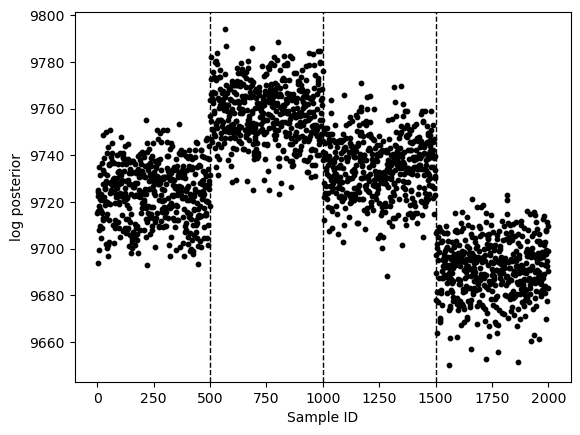

In [ ]:
plt.scatter(range(2000), samples['lp__'], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')
plt.show()

The sampling diagnostics and log posterior trace indicate good chain mixing and convergence. No re-sampling was necessary.

### Saving the Posterior Samples

We persist the posterior samples obtained from the Bayesian model to disk using Python’s `pickle` module.

Saving the `samples` object allows us to:

- Avoid re-running the expensive MCMC inference step,
- Share or reload posterior results for later analysis and comparison,
- Support reproducibility of results.

The file is stored as `stan_model_fit_foodweb_baywet.pkl`. This includes all posterior draws for the model parameters and can be reloaded in future sessions for downstream inference or visualization.

In [ ]:
#Saving the model
import pickle
filename = 'stan_model_fit_foodweb_baywet.pkl'
try:
    with open(filename, 'wb') as f:
        pickle.dump(samples, f)
    print(f"Stan fit object successfully saved to {filename}")
except Exception as e:
    print(f"Error saving fit object: {e}")

Stan fit object successfully saved to stan_model_fit_foodweb_baywet.pkl


In [ ]:
import pickle
filename = 'stan_model_fit_foodweb_baywet.pkl'

samples = None
try:
    with open(filename, 'rb') as f:
        samples = pickle.load(f)
    print(f"Stan fit object successfully loaded from {filename}")

except FileNotFoundError:
    print(f"Error loading fit object: File not found at {filename}")
except Exception as e:
    print(f"Error loading fit object: {e}")

Stan fit object successfully loaded from stan_model_fit_foodweb_baywet.pkl


### Summary of Posterior Samples

This output presents a truncated summary of the posterior distributions for the main model parameters, based on 2000 post-warmup samples across 4 Markov chains.

Key statistics reported for each parameter include:

- `mean`: posterior mean estimate,
- `sd`: posterior standard deviation (spread),
- `2.5%`, `25%`, `50%`, `75%`, `97.5%`: quantiles indicating uncertainty ranges,
- `lp__`: log posterior density values for model diagnostics.

The parameters include:

- `C`: global sampling effort,
- `r`: interaction preference multiplier,
- `sigma[i]`, `tau[j]`: taxa-level abundance weights for resources and consumers respectively,
- `rho`: prior interaction probability between taxa.

Due to the large number of parameters (e.g., `sigma[1]` to `sigma[128]`), only the first 100 are shown. Full diagnostics (`n_eff`, `Rhat`) are omitted in this summary because the model exceeds the default threshold. These should be manually inspected if convergence issues are suspected.

In [ ]:
samples


For the full summary use 'print(fit)'

Inference for Stan model: plant_pol_e215d9f28a31a5a7790444e1b0d7f7ff.
4 chains, each with iter=2500; warmup=2000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C          35.12     nan  20.85    9.97  18.16  28.39   51.2   77.7    nan    nan
r          1.6e4     nan  1.8e4  976.96 1651.3 6092.0  2.8e4  5.8e4    nan    nan
sigma[1]  5.5e-3     nan 6.2e-3  1.1e-4 1.4e-3 3.5e-3 7.3e-3   0.02    nan    nan
sigma[2]  5.6e-3     nan 6.2e-3  8.8e-5 1.3e-3 3.6e-3 7.8e-3   0.02    nan    nan
sigma[3]  5.4e-3     nan 6.0e-3  8.5e-5 1.1e-3 3.4e-3 7.3e-3   0.02    nan    nan
sigma[4]  5.4e-3     nan 5.9e-3  1.1e-4 1.4e-3 3.5e-3 7.3e-3   0.02    nan    nan
sigma[5]  5.5e-3     nan 6.1e-3  8.7e-5 1.2e-3 3.4e-3 7.6e-3   0.02    nan    nan
sigma[6]  5.7e-3     nan 6.7e-3  6.2e-5 1.2e-3 3.5e-3 7.6e-3   0.02    nan    nan
sigma[7]  5.5e-3     nan 5.7e-3  8.

## Posterior-predictive check

### Posterior Predictive Matrix

We now generate the posterior predictive matrix `M_tilde`, which represents the expected number of interactions between each taxon pair, averaged over all posterior samples.

Each entry $\tilde{M}_{ij}$ is computed as:

$$
\tilde{M}_{ij} = \frac{1}{S} \sum_{s=1}^{S} C^{(s)} \cdot r^{(s)} \cdot \sigma_i^{(s)} \cdot \tau_j^{(s)} \cdot Q_{ij}^{(s)}
$$

This matrix reflects the model’s predicted interaction structure and will be used for comparison against the observed data and in subsequent model diagnostics.

In [ ]:
M_tilde = pp.get_posterior_predictive_matrix(samples)

### Comparing Observed and Predicted Interaction Matrices

We now visualize the observed interaction matrix alongside the posterior predictive matrix to assess how well the model captures trophic structure.

The first plot shows the empirical matrix `M`, where each cell represents the number of observed interactions from a resource to a consumer taxon. Interactions are sparse and highly concentrated in a small subset of taxa pairs.

The second plot shows the posterior predictive matrix `M_tilde`, which reflects the model’s expected number of interactions averaged over posterior samples. This matrix is smoother and non-zero across a broader range, accounting for uncertainty and latent interaction structure.

This comparison allows us to evaluate the model’s fit to the empirical data, identify areas of under- or over-prediction, and detect broader patterns that might be missed in sparse raw observations.

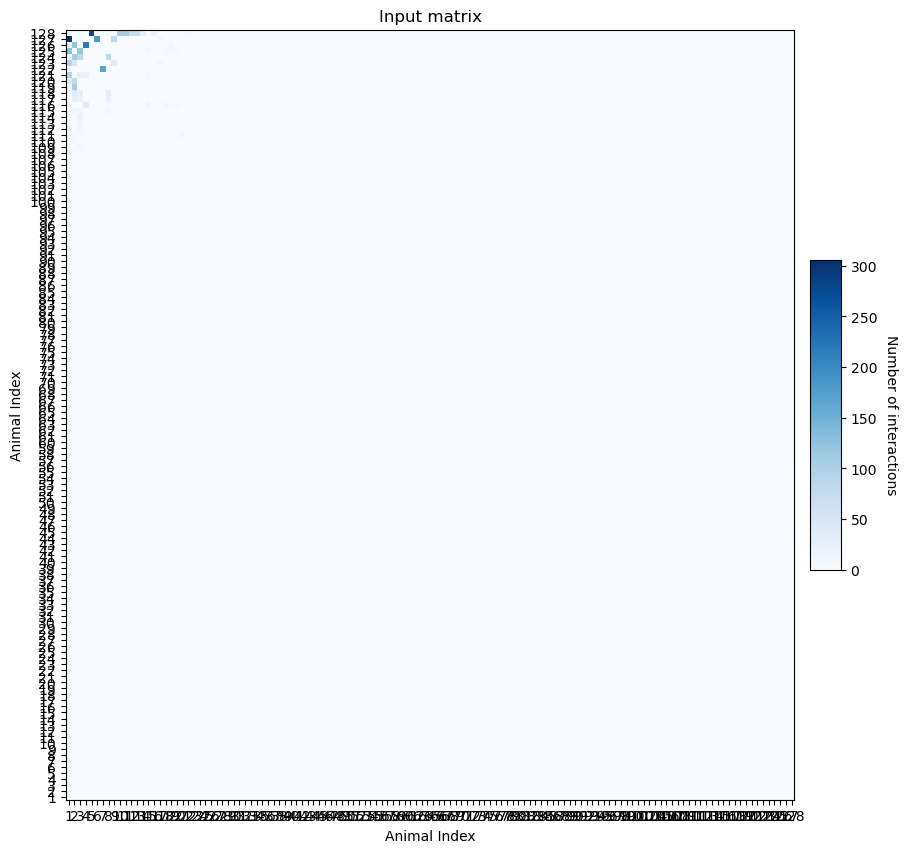

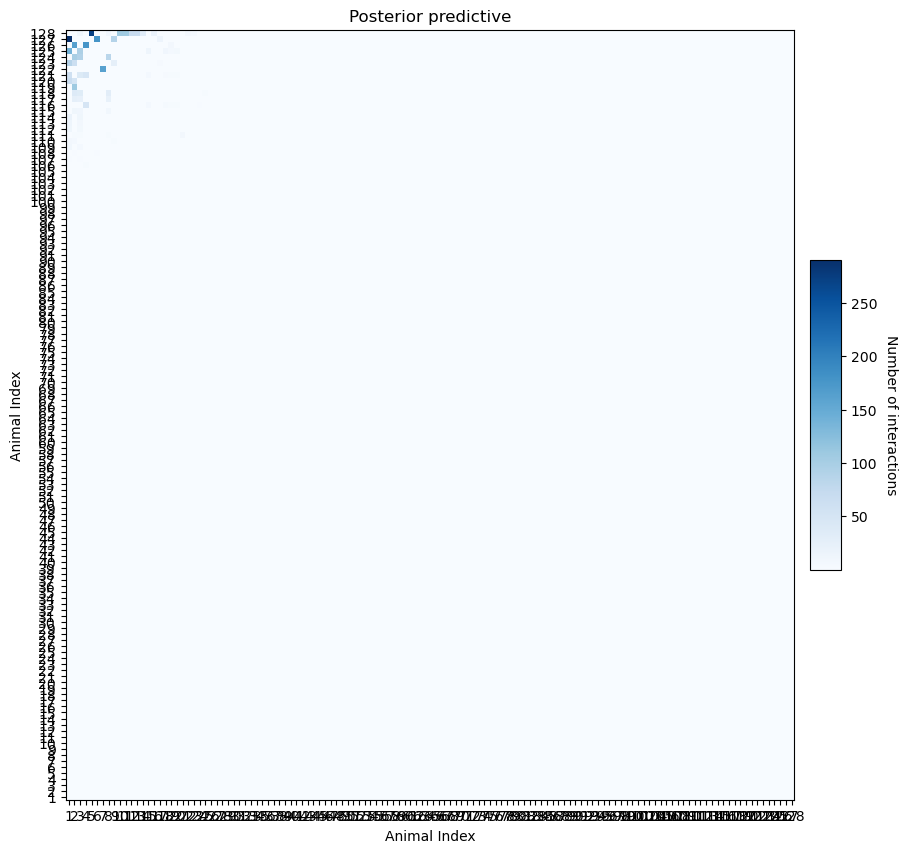

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Input matrix')
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Animal Index')
plt.ylabel('Animal Index')
plt.figure(figsize=(10,10))
plt.title('Posterior predictive')
plt.pcolormesh(M_tilde, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Animal Index')
plt.ylabel('Animal Index')
plt.show()


### Residual Distribution: Observed vs. Predicted Interactions

This histogram visualizes the distribution of residuals:

$$
M_{ij} - \langle \tilde{M}_{ij} \rangle
$$

Each bar counts the number of taxon pairs whose observed interaction deviates from the model’s posterior predictive mean by a given amount.

The sharp concentration at zero indicates that, for most species pairs, the model’s predictions closely match the observed data. Residuals outside zero highlight mismatches, pointing to either over- or under-prediction.

This plot is useful for diagnosing model fit and detecting systematic biases in prediction across the network.

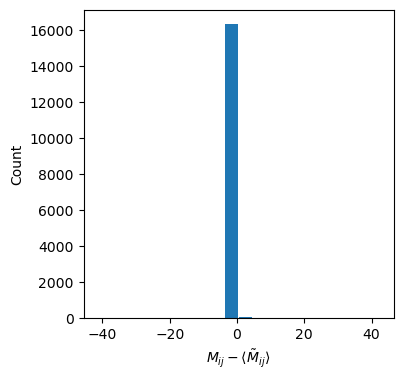

In [ ]:
plt.figure(figsize=(4,4))
plt.hist((M-M_tilde).flatten(), density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$M_{ij}-\langle \tilde{M}_{ij}\rangle$')
plt.ylabel('Count')
plt.show()

### Posterior Predictive vs. Observed Data (Fig. 2)

The plot below compares the observed number of interactions with the model’s posterior predictions for each taxon pair.

The x-axis lists species pairs, sorted by observed interaction count. For each pair:

- Black squares show the observed values $M_{ij}$
- Blue dots indicate the posterior predictive means $\mathbb{E}[\tilde{M}_{ij}]$
- Gray error bars represent the 95% credible interval: between the 2.5th and 97.5th percentiles of posterior samples

This plot helps visually assess whether the model is accurately predicting observed interaction counts and how much uncertainty it assigns to each estimate.

A good fit is indicated when most observed data points lie within the model's 95% credible intervals.

In [ ]:
posterior_samples = pp.get_posteriors_predictive_matrices(samples)

# Calculate the 97.5th percentile along the first axis (axis=0)
upper_bound_matrix = np.percentile(posterior_samples, 97.5, axis=0)

# Calculate the 2.5th percentile along the first axis (axis=0)
lower_bound_matrix = np.percentile(posterior_samples, 2.5, axis=0)


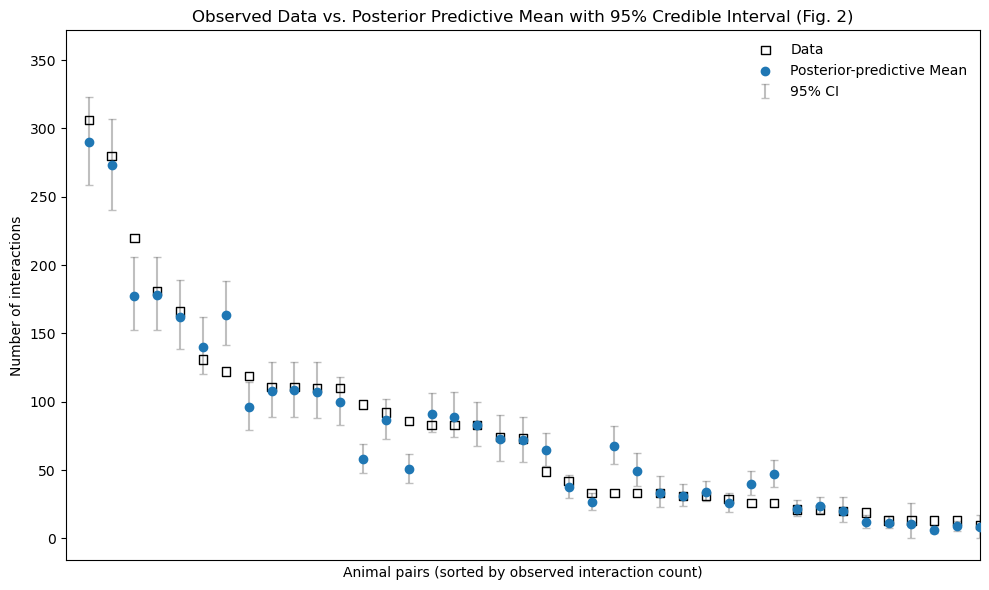

In [ ]:
plt.figure(figsize=(10, 6))
sort_order = np.argsort(-M.flatten())

M_flat_sorted = M.flatten()[sort_order]
M_tilde_mean_flat_sorted = M_tilde.flatten()[sort_order]
lower_bounds_flat_sorted = lower_bound_matrix.flatten()[sort_order]
upper_bounds_flat_sorted = upper_bound_matrix.flatten()[sort_order]

lower_errors = M_tilde_mean_flat_sorted - lower_bounds_flat_sorted
upper_errors = upper_bounds_flat_sorted - M_tilde_mean_flat_sorted
yerr_values = [lower_errors, upper_errors]

x_values = range(1, len(sort_order) + 1)


plt.scatter(x_values, M_flat_sorted, marker='s', facecolors='none', edgecolors='k', label='Data', zorder=5)
plt.scatter(x_values, M_tilde_mean_flat_sorted, label='Posterior-predictive Mean', zorder=10)

plt.errorbar(x_values, M_tilde_mean_flat_sorted, yerr=yerr_values, fmt='none',
             capsize=3, color='gray', alpha=0.5, label='95% CI', zorder=0)


plt.xlim(0,40)

plt.xticks([])

plt.xlabel('Animal pairs (sorted by observed interaction count)')
plt.ylabel(r'Number of interactions')

min_y = min(M_flat_sorted.min(), lower_bounds_flat_sorted.min())
max_y = max(M_flat_sorted.max(), upper_bounds_flat_sorted.max())

plt.ylim(min_y - abs(min_y)*0.1 - (max_y - min_y)*0.05, max_y + abs(max_y)*0.1 + (max_y - min_y)*0.05)
plt.legend(frameon=False, markerfirst=True, loc='upper right')

plt.title('Observed Data vs. Posterior Predictive Mean with 95% Credible Interval (Fig. 2)')
plt.tight_layout()
plt.show()

### Posterior Predictive Fit: Quantitative Check

To evaluate the quality of the Bayesian model beyond visual agreement, we apply a formal goodness-of-fit test. The chi-square-like statistic $ X^2 $, defined as the sum of squared differences between the observed matrix $ M $ and the posterior predictive mean $\tilde{M}$, normalized by the predictive mean, quantifies how well the model reproduces the data.

This value is then compared to a reference distribution derived from a chi-squared distribution with degrees of freedom equal to the number of entries in the interaction matrix. We simulate this distribution under the null hypothesis that the model offers no structural advantage—that is, it performs no better than chance.

For the `FOODWEB-BAYWET` network, the calculated discrepancy is approximately 1,018.24. The expected discrepancy under the null model is around 16,383.14, with the 5th percentile of this distribution at 16,086.10. Because our model’s discrepancy is far below this threshold, we can reject the null hypothesis with high confidence.

This result confirms that our Bayesian model captures the interaction structure of the ecosystem with much greater fidelity than would be expected under a random model, reinforcing the conclusions drawn from our visual analyses.

In [ ]:
X_2=np.sum((M-M_tilde)**2/M_tilde)
print(f"\nCalculated Discrepancy (X^2): {round(X_2,2)}")
from scipy.stats import chi2
num_simulations=10000
degrees_of_freedom = n_p * n_a

  # Generate random samples from the chi-square distribution
chi_samples = chi2.rvs(df=degrees_of_freedom, size=num_simulations)

  # Estimate the expected value as the mean of the samples
estimated_expected_value = np.mean(chi_samples)

print(f"\nIf Estimated Discrepancy (X^2) is lower than: {round(np.percentile(chi_samples,5),2)}")
print(", we can affirm with 95% confidence or more that our model is better than a random/obsolete model")
print(f"\nExpected Discrepancy (X^2): {round(estimated_expected_value,2)}")


Calculated Discrepancy (X^2): 1018.24

If Estimated Discrepancy (X^2) is lower than: 16086.1
, we can affirm with 95% confidence or more that our model is better than a random/obsolete model

Expected Discrepancy (X^2): 16383.14


### Posterior Edge Probability Estimation

We now estimate the posterior probability of each potential interaction in the ecological network using the `estimate_network()` function.

This function computes the average edge probability matrix $ Q $ across all posterior samples, where each entry $Q_{ij}$ represents the inferred probability that an interaction exists from taxon $ i $ to taxon $j $, given the data and model.

The resulting matrix `edge_prob` encodes the latent structure of the network and forms the basis for downstream predictions and threshold-based reconstructions.

In [ ]:
edge_prob = pp.estimate_network(samples)

### Fig. 1(c): Edge Probabilities and Abundance Distributions

This visualization combines three outputs from the Bayesian inference model:

- The **central heatmap** shows the posterior edge probability matrix $Q$, where each cell $Q_{ij}$ represents the inferred probability that taxon $j$ consumes taxon $i$.
- The **top histogram** displays the posterior mean values of $\tau_j$, the relative abundances of consumer taxa.
- The **right histogram** shows the posterior mean values of $\sigma_i$, the relative abundances of resource taxa.

The edge probability matrix reveals a concentrated region of likely interactions near the top-left, reflecting a highly skewed structure where only a subset of taxa are strongly connected. Meanwhile, both $\sigma$ and $\tau$ exhibit long-tailed distributions, indicating that a few taxa account for most of the activity in the network. These patterns are consistent with the trophic organization expected in ecological systems, and align with the structure presented in Fig. 1(c) of Young et al.

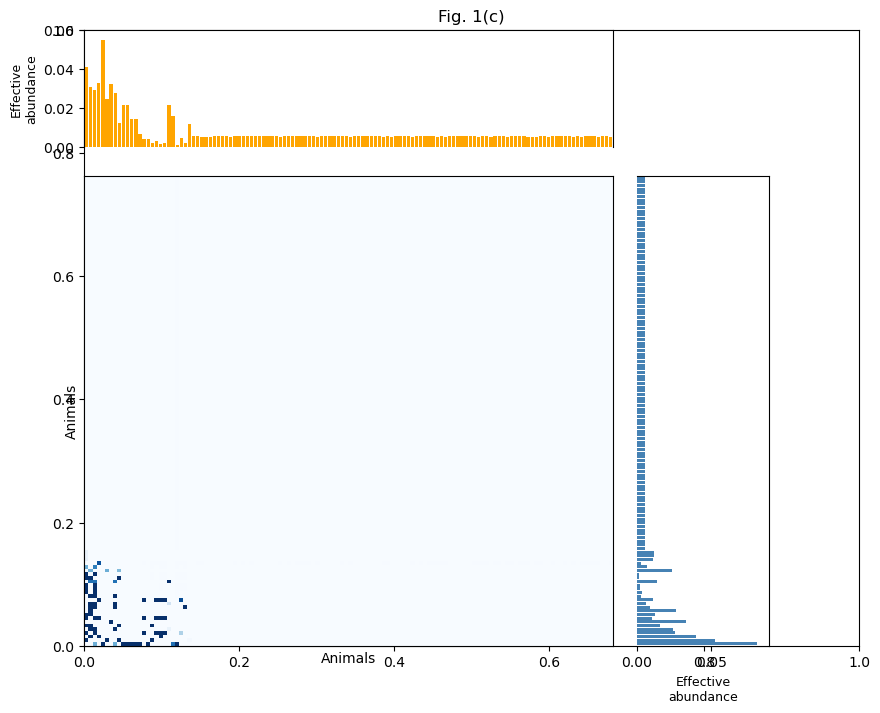

In [ ]:
pp.figure_1_c(samples,n_a,n_p)

### Subset View of Interaction Predictions

To inspect the model's predictions at a finer scale, we extract and visualize a subset of taxa from the full interaction matrices.

Using the top 30 consumers and 30 resources (based on inferred abundance or interaction frequency), we compare:

- The empirical interaction matrix $M$
- The posterior predictive mean $\tilde{M}$
- The posterior edge probability matrix $Q$

These side-by-side visualizations are especially useful for:

- Identifying specific pairs with high predicted interaction probability or strength
- Detecting mismatches between observed and predicted values
- Evaluating the confidence of inferred links, particularly in sparsely observed regions

This focused diagnostic complements global summaries by revealing how the model performs on specific, ecologically relevant taxa.

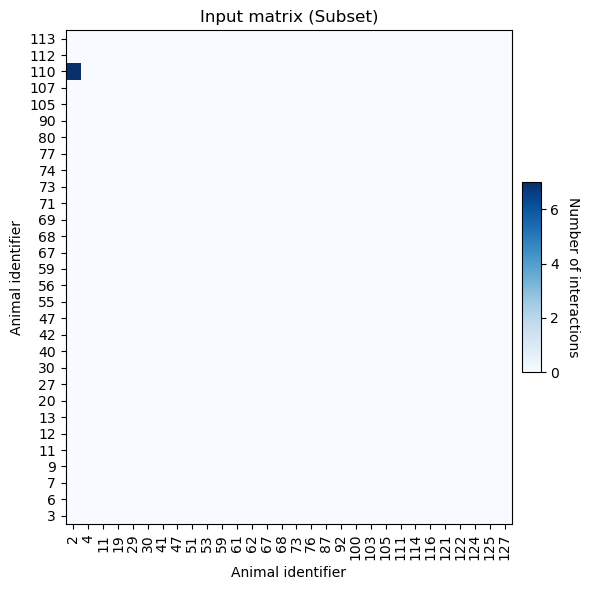

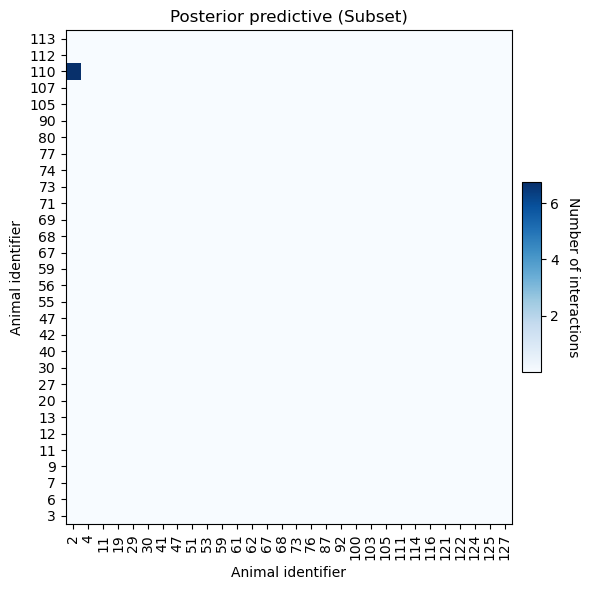

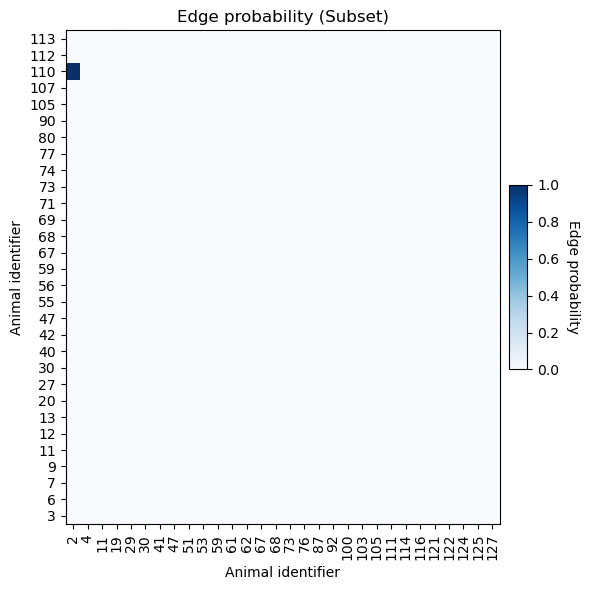

In [ ]:
# Define the desired subset size
subset_animals = 30


# Call the plotting function
pp.plot_subset_interaction_matrices(
    M,
    M_tilde,
    edge_prob,
    n_p,
    n_a,
    subset_animals,
    subset_animals
)

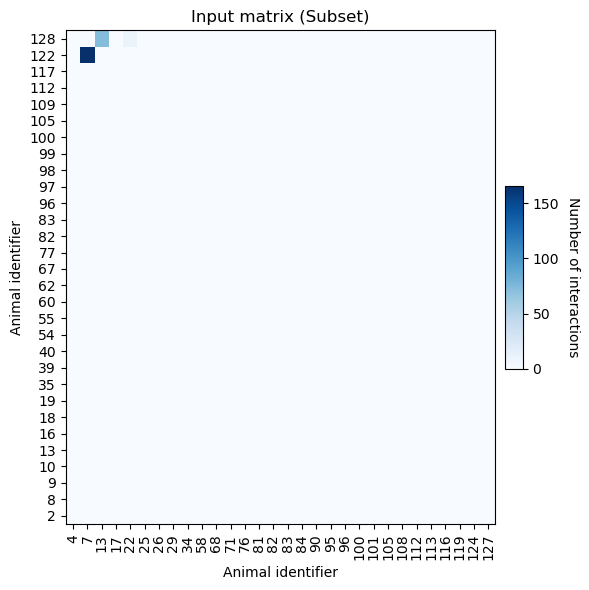

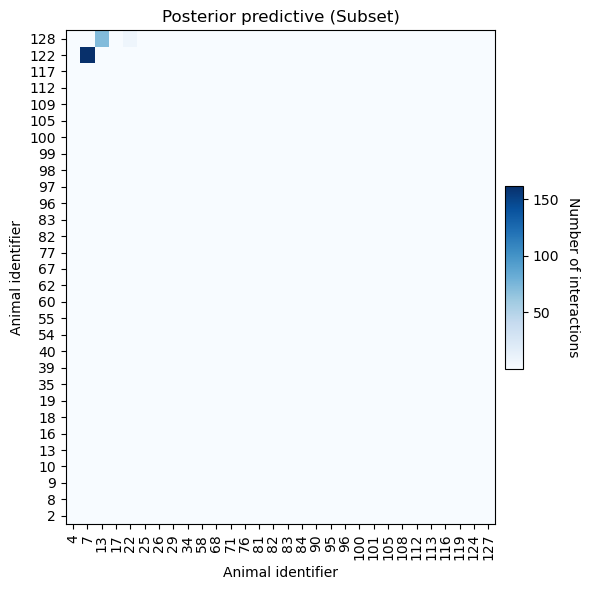

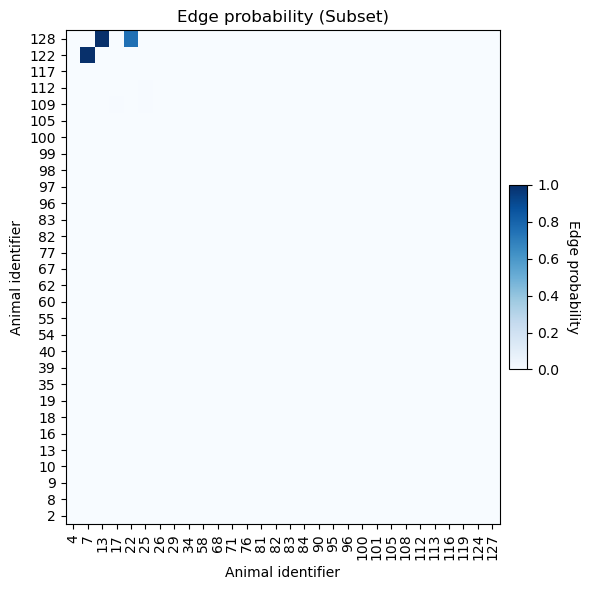

In [ ]:
# Define the desired subset size
subset_animals = 30


# Call the plotting function
pp.plot_subset_interaction_matrices(
    M,
    M_tilde,
    edge_prob,
    n_p,
    n_a,
    subset_animals,
    subset_animals
)

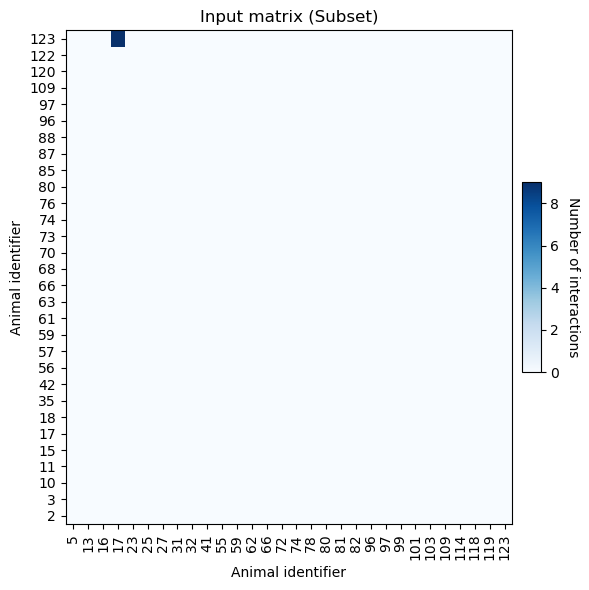

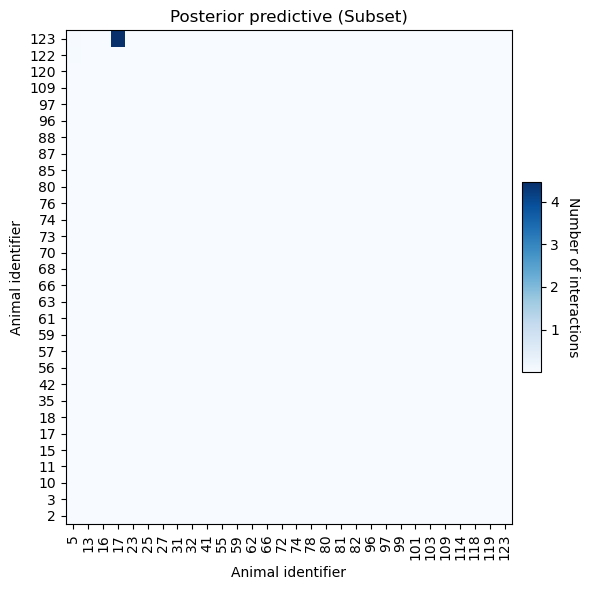

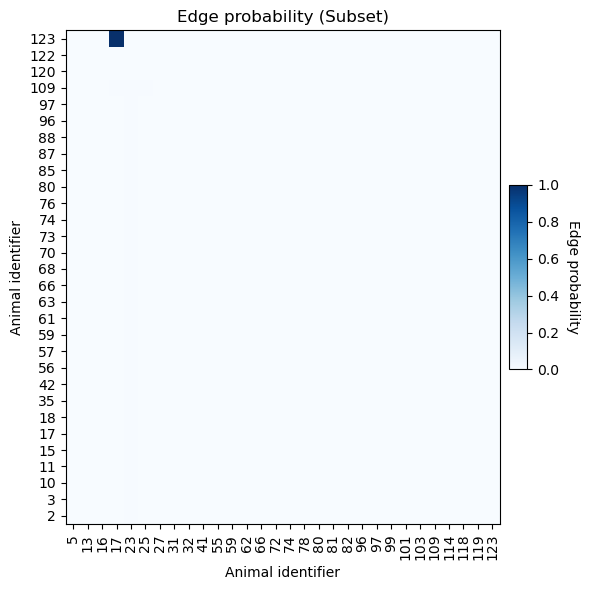

In [ ]:
# Define the desired subset size
subset_animals = 30


# Call the plotting function
pp.plot_subset_interaction_matrices(
    M,
    M_tilde,
    edge_prob,
    n_p,
    n_a,
    subset_animals,
    subset_animals
)

### Posterior Mean of Network Connectance

The posterior mean of the connectance parameter $\rho$ is:

$$
\hat{\rho} = 0.0069
$$

This value reflects the expected probability that any given consumer–resource pair in the network is connected. A connectance of approximately 0.0069 confirms that the trophic interaction network is extremely sparse, with fewer than 1% of all possible interactions being realized.

In [ ]:
round(samples['rho'].mean(),4)

np.float64(0.0069)

### Posterior Distribution of Connectance $\rho$

The histogram above shows the posterior distribution of the connectance parameter $\rho$.

Each bar reflects the number of posterior samples falling within a given bin of $\rho$ values. The distribution is sharply concentrated between 0.004 and 0.010, with the peak near $\hat{\rho} = 0.0069$.

This supports the conclusion that the inferred trophic network is sparse, as only a small proportion of all possible species pairs are likely to be connected through feeding interactions.

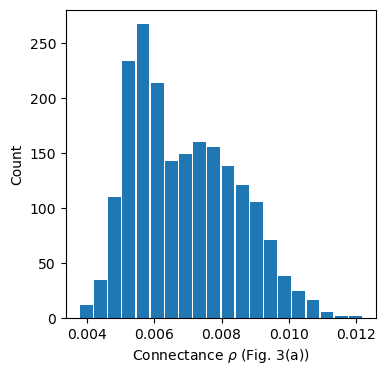

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(samples['rho'], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'Connectance $\rho$ (Fig. 3(a))')
plt.ylabel('Count')
plt.show()

### Posterior Distribution of Preference Parameter $r$

The histogram above displays the posterior distribution of the interaction preference parameter $r$.

This parameter controls the extent to which observed interactions are overdispersed relative to a Poisson model. Higher values of $r$ allow the model to accommodate larger deviations from uniform interaction rates.

As shown, the distribution is highly skewed: the majority of samples fall in lower ranges, but the tail extends to very large values. This heavy-tailed structure indicates substantial variation in inferred interaction intensities, with some pairs being strongly preferred.

Such flexibility is essential to capturing realistic feeding patterns in trophic systems, where a few taxa may dominate in terms of interaction volume.

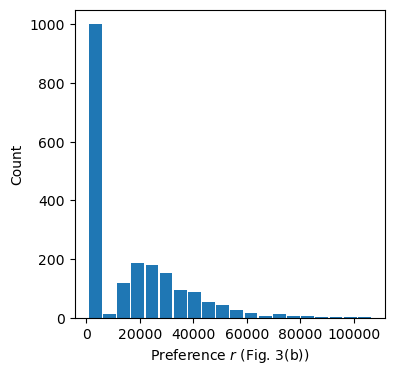

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(samples['r'], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'Preference $r$ (Fig. 3(b))')
plt.ylabel('Count')
plt.show()

### Posterior Distribution of Nestedness (NODF)

This plot shows the distribution of NODF (Nestedness metric based on Overlap and Decreasing Fill) values computed from binary networks sampled from the posterior.

Each binary matrix is generated by thresholding posterior edge probabilities with a Bernoulli draw, effectively producing a sampled interaction network. For each of these realizations, the NODF is computed to quantify how nested the inferred food web is.

The histogram indicates that most posterior samples exhibit relatively low levels of nestedness, with a concentration of values between 0.05 and 0.20.

The mean nestedness across all sampled networks is:

$$
\mathbb{E}[\text{NODF}] \approx 0.1207
$$

This reflects a modest tendency toward nested interaction structure in the wet-season network, with substantial variability across posterior samples.

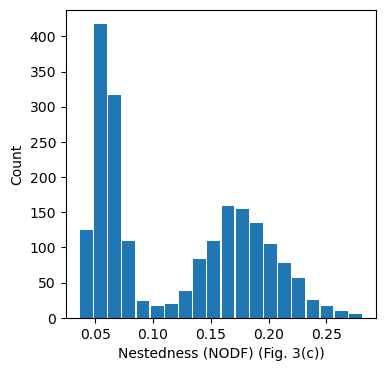

In [ ]:
from scipy.stats import bernoulli
edge_probability_matrices=pp.estimate_networks(samples)

for i in range(edge_probability_matrices.shape[0]):
    edge_probability_matrices[i,:,:]=bernoulli.rvs(edge_probability_matrices[i,:,:])

nodf_values=np.zeros(edge_probability_matrices.shape[0])

for i in range(edge_probability_matrices.shape[0]):
    nodf_values[i] = pp.compute_nodf(edge_probability_matrices[i,:,:])

plt.figure(figsize=(4,4))
plt.hist(nodf_values, density=False, bins=20, rwidth=0.9);

plt.xlabel("Nestedness (NODF) (Fig. 3(c))")
plt.ylabel('Count')
plt.show()

In [ ]:

print(np.mean(nodf_values))

0.12065132939527075


### Edge Probability Variability Across Posterior Samples

This plot visualizes the standard deviation of posterior edge probabilities across all sampled networks. Each matrix entry represents the variability in the probability that a particular consumer-resource interaction exists, based on the posterior distribution.

Higher variability (darker blue) suggests greater uncertainty in whether that interaction truly occurs, while low variability (lighter or white regions) reflects consistent agreement across samples—either confidently present or absent.

This map of uncertainty is particularly useful for identifying species pairs that require further data collection, as well as highlighting potentially context-dependent interactions in the wet-season network.

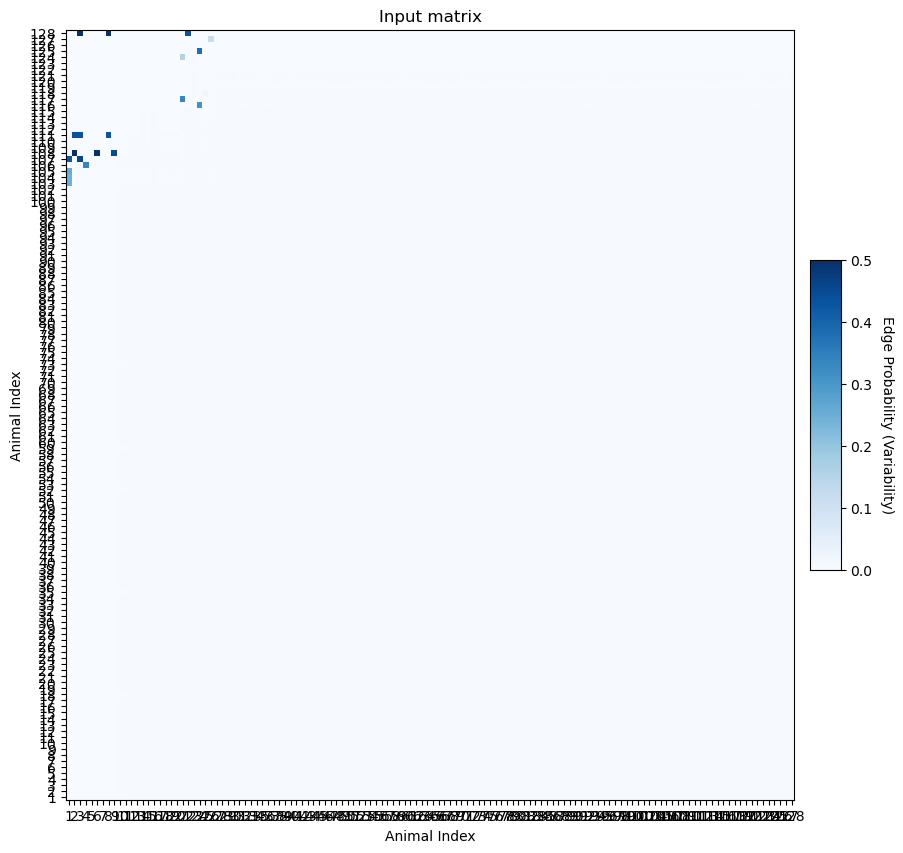

In [ ]:
edge_probability_matrices=pp.estimate_networks(samples)

plt.figure(figsize=(10,10))
plt.title('Input matrix')
plt.pcolormesh(edge_probability_matrices.std(axis=0), cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Edge Probability (Variability)', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Animal Index')
plt.ylabel('Animal Index')
plt.show()

### Interaction Count Variability Across Posterior Samples

This heatmap shows the standard deviation of predicted interaction counts across all posterior predictive matrices. Each cell represents the uncertainty in the predicted number of interactions between a given resource and consumer taxon.

Brighter cells indicate higher variability—taxon pairs for which the model produces a wider range of predictions across samples. Darker or white cells indicate more stable predictions, either consistently low or consistently high.

This diagnostic helps detect which parts of the network are well constrained by the data and which exhibit uncertainty, potentially due to limited observations or ambiguous evidence of interaction.

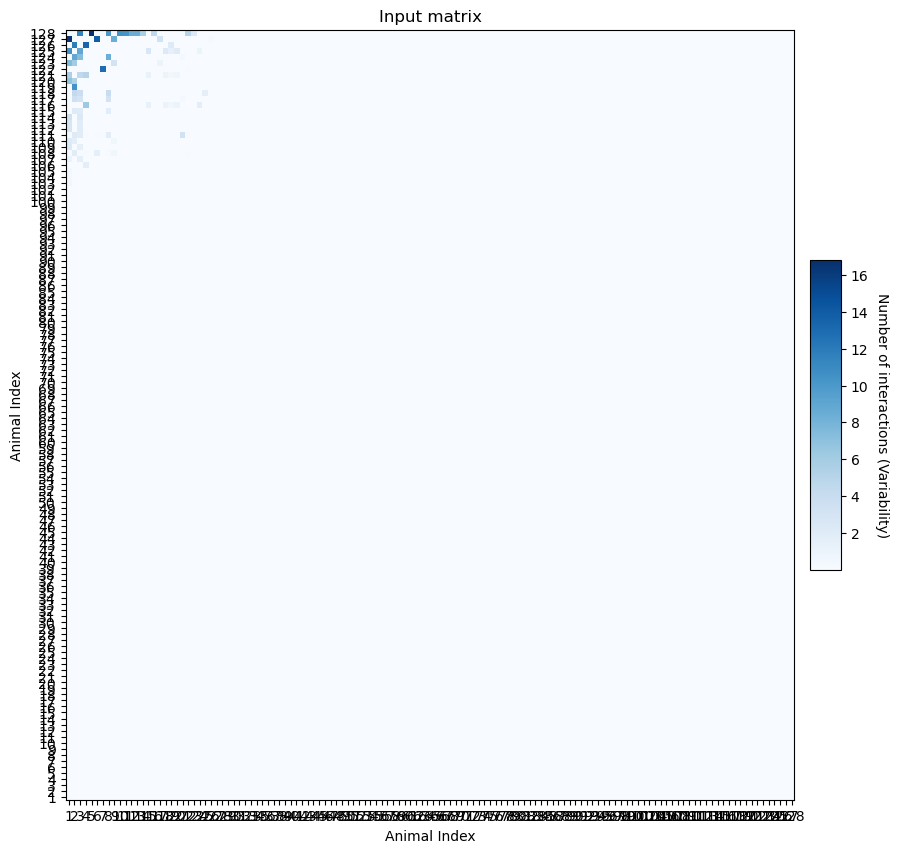

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Input matrix')
plt.pcolormesh(posterior_samples.std(axis=0), cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions (Variability)', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Animal Index')
plt.ylabel('Animal Index')
plt.show()

### Observed vs.Estimated Animal Abundances

This scatter plot compares two key quantities for each taxon in the network:

- The horizontal axis shows the total number of observed interactions (i.e., the row sum of the input matrix $M$), which reflects how frequently each taxon is empirically detected as a consumer.
- The vertical axis displays the corresponding posterior mean of $\sigma$, the inferred relative abundance of each consumer taxon under the Bayesian model.

The figure provides an important diagnostic: it evaluates whether the model’s inferred animal abundances align with empirical sampling frequencies.

In general, we expect a positive relationship — more frequently observed taxa should tend to have higher inferred abundances — but the model also regularizes and smooths this relationship to account for noise and sampling bias. Deviations from a perfect line reflect latent structure captured by the model.


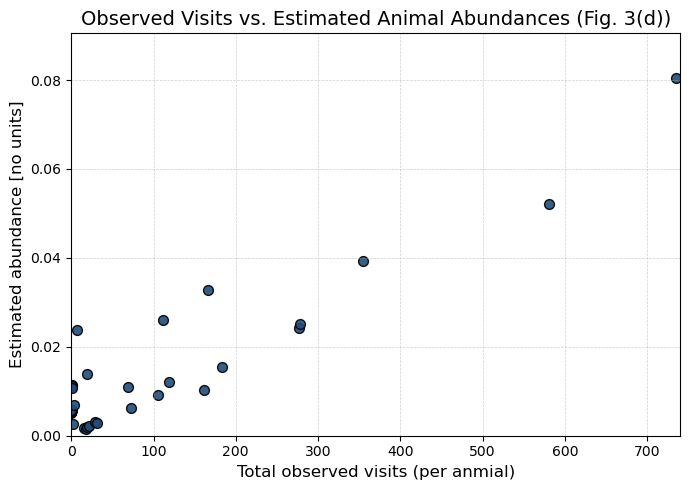

In [ ]:
# Compute observed total visits per animal (row sums of the M matrix)
observed_visits = M.sum(axis=1)  # M is the observed animal–animal interaction matrix

# Compute posterior mean of sigma for each animal
sigma_mean = samples['sigma'].mean(axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(
    observed_visits,
    sigma_mean,
    s=50,
    color="#1f4e79",
    edgecolor="black",
    alpha=0.9
)

# Axis labeling and formatting
ax.set_title("Observed Visits vs. Estimated Animal Abundances (Fig. 3(d))", fontsize=14)
ax.set_xlabel("Total observed visits (per anmial)", fontsize=12)
ax.set_ylabel("Estimated abundance [no units]", fontsize=12)
ax.set_xlim(0, observed_visits.max() + 5)
ax.set_ylim(0, max(sigma_mean) + 0.01)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

### Posterior Edge Probabilities Under Varying Data Regimes

This figure compares the distribution of posterior edge probabilities $Q_{ij}$ under two conditions:

- **Fig. 4(a)** (top panel) shows edge probabilities when only half the data are used (a simulated low-data scenario). Most probabilities are close to zero, indicating strong uncertainty — the model tends to be conservative and avoids inferring interactions without sufficient evidence.
  
- **Fig. 4(b)** (bottom panel) shows edge probabilities when all available data are used. The distribution is still skewed toward zero, consistent with the network’s sparsity, but has a longer tail — more edges receive non-negligible support due to the greater statistical power.

This visualization illustrates how data quantity affects the model’s confidence. When observational coverage is low, the posterior is heavily biased toward zero (i.e., few predicted interactions). With full data, the posterior can resolve more structure and highlight plausible but previously unobserved edges.

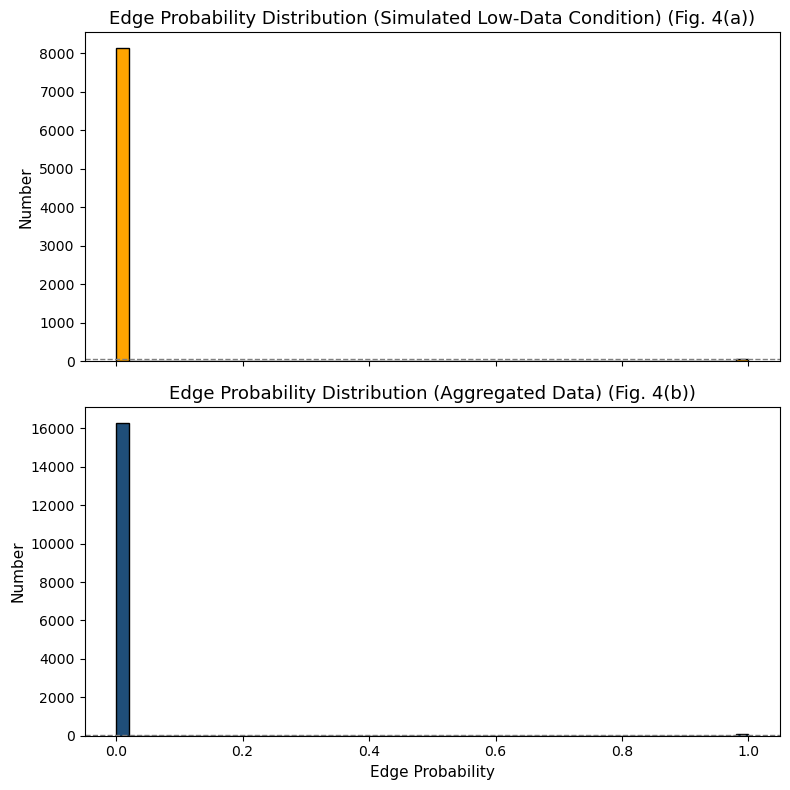

In [ ]:
# Simulate a low-data condition by subsampling rows
M_sub, sub_idx = pp.subsample_matrix(M, frac=0.5)
sigma_samples_sub = [sigma[sub_idx] for sigma in samples['sigma']]

# Compute posterior edge probabilities
Q_sub = pp.average_edge_probs(M_sub, samples['C'], samples['r'], samples['rho'], sigma_samples_sub, samples['tau'])
Q_full = pp.average_edge_probs(M, samples['C'], samples['r'], samples['rho'], samples['sigma'], samples['tau'])

# Flatten for plotting
qvals_sub = Q_sub.flatten()
qvals_full = Q_full.flatten()

# Plot histograms
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Figure 4a – subsampled (orange bars)
ax1.hist(qvals_sub, bins=50, color="orange", edgecolor='black')
ax1.axhline(50, color='gray', linestyle='--', linewidth=1)
ax1.set_title("Edge Probability Distribution (Simulated Low-Data Condition) (Fig. 4(a))", fontsize=13)
ax1.set_ylabel("Number", fontsize=11)

# Figure 4b – full data (blue bars)
ax2.hist(qvals_full, bins=50, color="#1f4e79", edgecolor='black')
ax2.axhline(50, color='gray', linestyle='--', linewidth=1)
ax2.set_title("Edge Probability Distribution (Aggregated Data) (Fig. 4(b))", fontsize=13)
ax2.set_xlabel("Edge Probability", fontsize=11)
ax2.set_ylabel("Number", fontsize=11)

plt.tight_layout()
plt.show()